# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.linear_model  import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = ['/datasets/geo_data_0.csv','/datasets/geo_data_1.csv','/datasets/geo_data_2.csv']
df = []
for ind in [0,1,2]:
    df.append(pd.read_csv(path[ind]))

Обзор данных

In [3]:
df[1].head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
df[0].head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df[1].head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
df[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df[2].head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
df[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Подготовка  выборок

In [10]:
features = []
targets = [] 

features_train = [0,1,2]
features_valid = [0,1,2]
target_train = [0,1,2]
target_valid = [0,1,2]

sr = RobustScaler()
num_cols = ['f0','f1','f2']

for area in [0,1,2]:
    # выделение признаков
    features.append(df[area].drop(['product','id'],axis = 1))
    targets.append(df[area]['product'])
    
    # получение выборок для обучения
    features_train[area],features_valid[area],target_train[area],target_valid[area] =\
        train_test_split(features[area],targets[area],test_size = .25, random_state = 12345)
    
    # маштабирование признаков
    features_train[area] = pd.DataFrame(sr.fit_transform(features_train[area]),columns = num_cols)
    features_valid[area] = pd.DataFrame(sr.transform(features_valid[area]),columns = num_cols)


## Обучение и проверка модели

Подбор параметров и обучение модели линейной регрессии 

In [11]:
grid_lin_reg = []
lin_reg = []
predictions = []
rmse = []
mean_deposit = []

for area in range(0,3):
    parametrs =  {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    lin_reg.append(LinearRegression())
    grid_lin_reg.append( GridSearchCV(lin_reg[area],parametrs,cv=5))
    grid_lin_reg[area].fit(features_train[area],target_train[area])
    predictions.append(grid_lin_reg[area].predict(features_valid[area]))
    rmse.append(mean_squared_error(target_valid[area],predictions[area])**(1/2))
    mean_deposit.append(predictions[area].mean())

In [12]:
grid_lin_reg[0].predict(features_valid[0])

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

Отклонение прогнозных запасов от фактических и среднее значение прогнозных запасов  

In [13]:
predictions_metrics = pd.DataFrame({'rmse':rmse, 'mean_depostit_oil':mean_deposit},index =['region_0','region_1','region_2'])
predictions_metrics

,rmse,mean_depostit_oil
region_0,37.579422,92.592568
region_1,0.893099,68.728547
region_2,40.029709,94.965046


Обращает внимание сильное различие метрики **rmse** у **region_1** в сравнении с другими областями, на величину примерно разницы  средних запасов

Посмотрим корреляцию признаков по регионам

In [14]:
pd.concat((df[0].corr(),df[1].corr(),df[2].corr()),axis = 1)

,f0,f1,f2,product,f0,f1,f2,product,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536,1.000000,0.182287,-0.001777,-0.030491,1.000000,0.000528,-0.000448,-0.001987
f1,-0.440723,1.000000,0.001724,-0.192356,0.182287,1.000000,-0.002595,-0.010155,0.000528,1.000000,0.000779,-0.001012
f2,-0.003153,0.001724,1.000000,0.483663,-0.001777,-0.002595,1.000000,0.999397,-0.000448,0.000779,1.000000,0.445871
product,0.143536,-0.192356,0.483663,1.000000,-0.030491,-0.010155,0.999397,1.000000,-0.001987,-0.001012,0.445871,1.000000


Существует практически полная  корреляция между признаком f2 и запасами у региона  с индексом 1. Один этот признак хорошо описывает прогнозные запасы

**region_1** имеет отклонение по запасам за счет сильной связи признака **f2**, или в  **product**  других регионах есть дополнительная погрешность примерно  размером  с их **rmse**

## Подготовка к расчёту прибыли

Вводные финансовые параметры 

In [15]:
BUDGET = 10**10
REV_OF_BARREL = 450*1000
EXPLORATION = 500
DEVELOPMENT = 200

# стоимость разработки скважины
COST_OF_FILD = BUDGET/DEVELOPMENT

# минимально необхадимый уровень запасов
STOCK_FOR_PAYBACK = COST_OF_FILD/REV_OF_BARREL
print('Необходимый для безубыточности уровень запасов в тыс. баррелей: {0:.4f}\n'.format(STOCK_FOR_PAYBACK))

Необходимый для безубыточности уровень запасов в тыс. баррелей: 111.1111



Формула расчета прибыли для лучших 200 скважин

In [16]:
def income_best_200(predicted_product,fact_product):
    fact_product = fact_product.reset_index(drop = True)
    best_predicted_filds_200 = predicted_product.sort_values(ascending = False)[:200]
    
    return (fact_product[best_predicted_filds_200.index] * REV_OF_BARREL - COST_OF_FILD).sum()   

Анализ величены средних прогнозных запасов

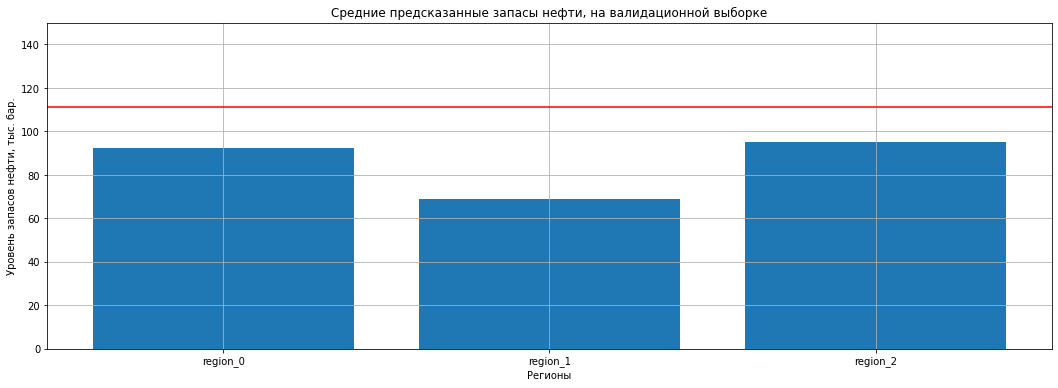

In [17]:
plt.figure(figsize=(18, 6))
plt.grid()
plt.ylim(0,150)
plt.bar(predictions_metrics.index,predictions_metrics['mean_depostit_oil'])
plt.axhline(STOCK_FOR_PAYBACK,color ='r')

plt.xlabel("Регионы")
plt.ylabel("Уровень запасов нефти, тыс. бар.")
plt.title("Средние предсказанные запасы нефти, на валидационной выборке")
plt.show()


Видно, что в среднем  разработка каждого разведанного месторождения приведет к генерации убытков в любом регионе, так как не в одном регионе они не достигают уровня безубыточности

## Расчёт прибыли и рисков 

Нахождение методом бутсрапа метрик качества прибыльности 200 скважин

In [18]:
state = np.random.RandomState(12345)

income_samples_mean = []
income_samples_sum = []

lower = []
upper = []
df_bootstrap = pd.DataFrame()
for area in range(3):
    income_samples = []
    for i in range(1000):
        product_500 = pd.Series(predictions[area]).sample(n=500,replace=True,random_state=state)
        income_samples.append(income_best_200(product_500, target_valid[area] ))
        
    df_bootstrap[area] = pd.Series(income_samples)/1000000
    income_samples_mean.append(pd.Series(income_samples).mean()/1000000)
    income_samples_sum.append(pd.Series(income_samples).mean()*200/1000000) 
    
    lower.append(df_bootstrap[area].quantile(0.025))
    upper.append(df_bootstrap[area].quantile(0.975))
    

Доверительный интервал в 95% по выборкам на основе Бутстрапа и среднее значение прибыли на скважину в миллионах рублей

In [19]:
financial_parametrs_of_deposits = pd.DataFrame({'lower_income':lower,'upper_income' : upper,'mean_income': income_samples_mean,
                                               'total_income_200' :income_samples_sum },
                                               index = ['region_0','region_1','region_2'])
financial_parametrs_of_deposits

,lower_income,upper_income,mean_income,total_income_200
region_0,-111.215546,909.766942,396.164985,79232.996960
region_1,78.050811,862.952060,461.155817,92231.163455
region_2,-112.227625,934.562915,392.950475,78590.095034


**Расчет рисков** 

Вычесление доли убыточных скважин

In [20]:

share_of_losses = []    
quantity_of_losses = []    
for area in range(3):
    quantity_of_losses.append(len(df_bootstrap[area][df_bootstrap[area] < 0]))
    share_of_losses.append(quantity_of_losses[area] / len(df_bootstrap[0])*100)
    len(df_bootstrap[area])

df_share_of_losses = pd.DataFrame({'share_of_losses' : share_of_losses },index = ['region_0','region_1','region_2'])    
    
for area in range(3):
    print('Процент убыточных скважин в регионе {0}: {1:.1f}% '.format(area, df_share_of_losses.iloc[area][0]))


Процент убыточных скважин в регионе 0: 6.9% 
Процент убыточных скважин в регионе 1: 0.7% 
Процент убыточных скважин в регионе 2: 6.5% 


Основные  финансовые показатели по 200 лучшим скважинам из 500 разведаных, на основании прогнозов модели линейной регрессии

In [21]:
pd.concat((financial_parametrs_of_deposits, df_share_of_losses),axis = 1)

,lower_income,upper_income,mean_income,total_income_200,share_of_losses
region_0,-111.215546,909.766942,396.164985,79232.996960,6.9
region_1,78.050811,862.952060,461.155817,92231.163455,0.7
region_2,-112.227625,934.562915,392.950475,78590.095034,6.5


Выводы:
   * получены результаты прогнозов запасов нефти моделью линейной регрессии и метрика отклонения запасов
   * выявляны страности в данных связанные с корреляцией признака f2
   * разработка месторождений  в **region_1** является лучшим решением,  на основании полученной более высокой средней прибыли от добычи нефти, а также наименьшим отклонением прогнозных запасов от фактических и наименьшим риском получения убытков
